# Anomalie NDVI 2008-2018

In [1]:
import pandas as pd

In [2]:
df = pd.read_pickle('ndvi+a_1981-2021.pickle')

Restringo il periodo temporale considerato da settimana 1 del 2008 a settimana 1 del 2018

In [3]:
df = df.loc[(df.Year>=2008) & (df.Year<=2018)]
df = df.drop(df.loc[(df.Year==2018) & (df.Week>1)].index).reset_index(drop=True)

Aggiungo colonna 'Date' per plottare i dati

In [4]:
df['Date'] = pd.to_datetime( df['Year'].astype(str) + df['Week'].astype(str) + "0", format='%G%V%w')

In [5]:
df = df[df.columns.tolist()[-1:] + df.columns.tolist()[:-1]]
df = df.iloc[:, 0:5] # risistemo il df e lo preparo per ricalcolare la media ciclostazionaria

In [6]:
df

,Date,Year,Week,NDVI_nord,NDVI_sud
0,2008-01-06,2008,1,0.126048,0.145688
1,2008-01-13,2008,2,0.120622,0.143976
2,2008-01-20,2008,3,0.121623,0.147884
3,2008-01-27,2008,4,0.125210,0.158479
4,2008-02-03,2008,5,0.131495,0.174398
...,...,...,...,...,...
509,2017-12-10,2017,49,0.163209,0.169064
510,2017-12-17,2017,50,0.153853,0.163516
511,2017-12-24,2017,51,0.146694,0.159441
512,2017-12-31,2017,52,0.137508,0.153907


Calcolo la media ciclostazionaria

In [7]:
media_nord = df.groupby('Week').apply(lambda x: x['NDVI_nord'].mean()).reset_index().rename(columns={0: 'media'})
media_sud = df.groupby('Week').apply(lambda x: x['NDVI_sud'].mean()).reset_index().rename(columns={0: 'media'})

In [8]:
df['anomalia_nord'] = df.apply(lambda x: x['NDVI_nord']-media_nord['media'].loc[media_nord.Week == x.Week].iloc[0], axis=1)
df['anomalia_sud'] = df.apply(lambda x: x['NDVI_sud']-media_sud['media'].loc[media_sud.Week == x.Week].iloc[0], axis=1)

In [9]:
df

,Date,Year,Week,NDVI_nord,NDVI_sud,anomalia_nord,anomalia_sud
0,2008-01-06,2008,1,0.126048,0.145688,-0.007605,-0.014047
1,2008-01-13,2008,2,0.120622,0.143976,-0.009652,-0.015223
2,2008-01-20,2008,3,0.121623,0.147884,-0.007479,-0.013040
3,2008-01-27,2008,4,0.125210,0.158479,-0.003054,-0.006896
4,2008-02-03,2008,5,0.131495,0.174398,0.000939,-0.000644
...,...,...,...,...,...,...,...
509,2017-12-10,2017,49,0.163209,0.169064,0.005993,-0.010838
510,2017-12-17,2017,50,0.153853,0.163516,0.005106,-0.010056
511,2017-12-24,2017,51,0.146694,0.159441,0.005048,-0.008412
512,2017-12-31,2017,52,0.137508,0.153907,0.001632,-0.008508


## Grafici

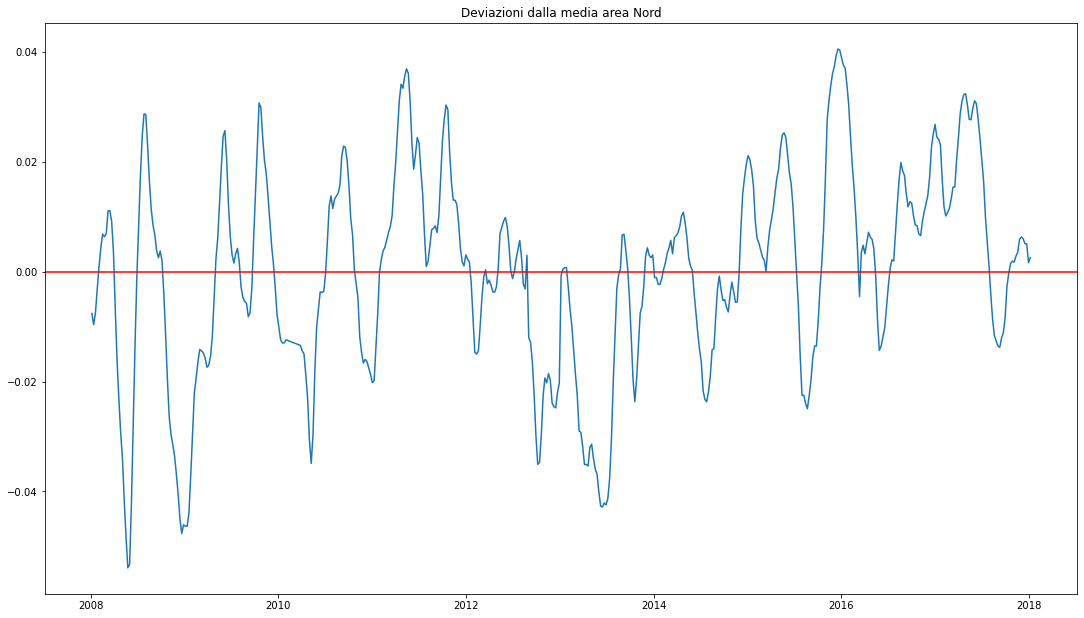

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(df['Date'], df['anomalia_nord'], label='anomalia_nord')
plt.title(label='Deviazioni dalla media area Nord')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

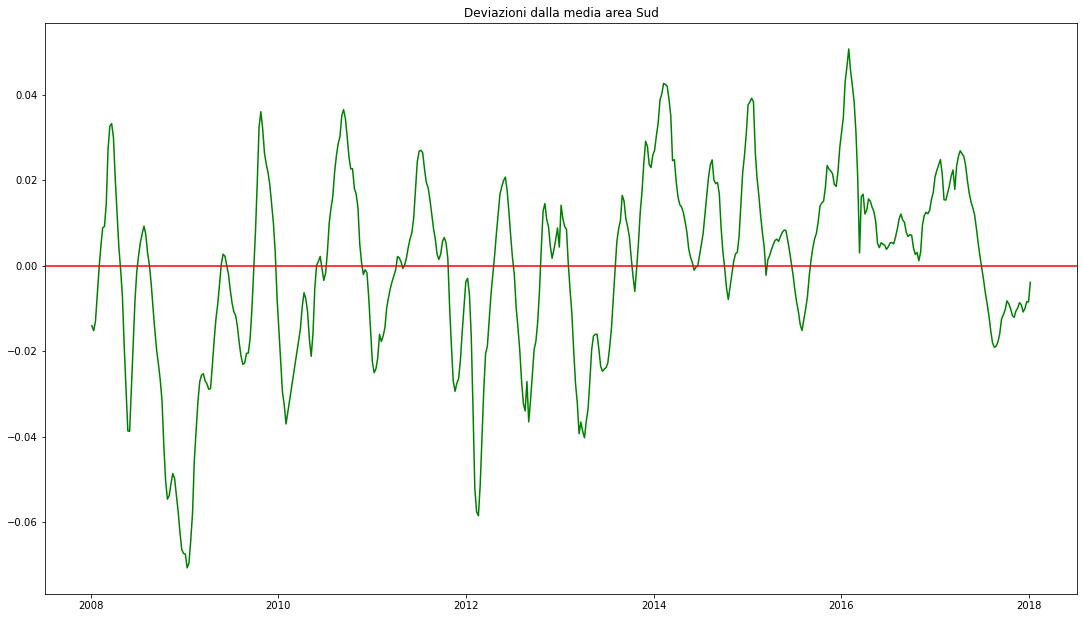

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(df['Date'], df['anomalia_sud'], label='anomalia_sud', color='g')
plt.title(label='Deviazioni dalla media area Sud')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

Grafici sovrapposti

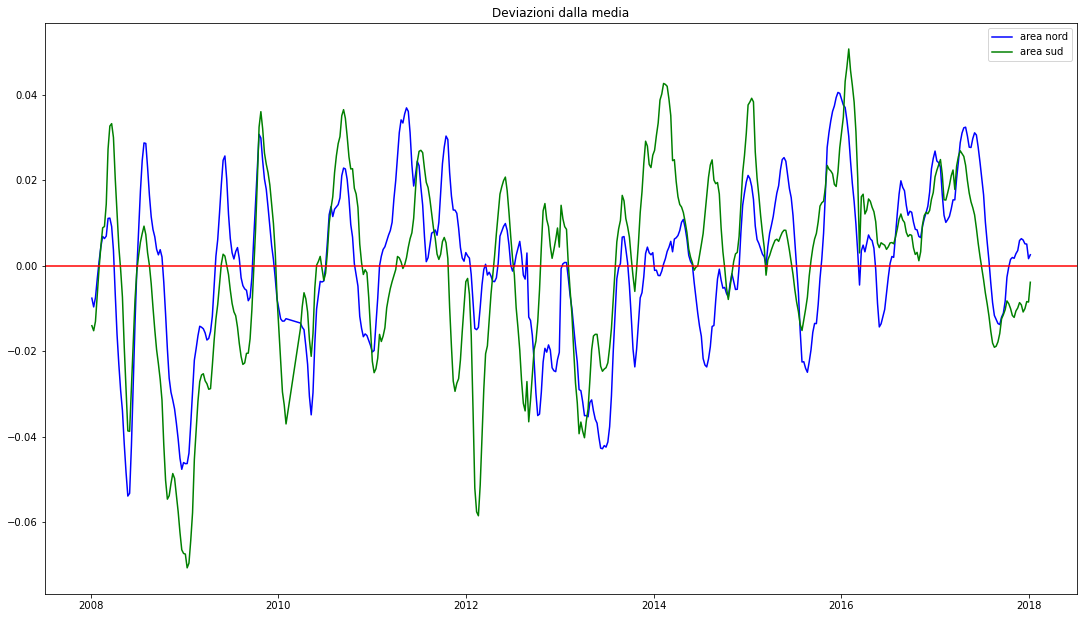

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(df['Date'], df['anomalia_nord'], label='area nord', color='b')
ax.plot(df['Date'], df['anomalia_sud'], label='area sud', color='g')
plt.legend()
plt.title(label='Deviazioni dalla media')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Feature selection

In [13]:
import src.preprocessing_functions as pp
import src.mixedRVMI as mx
from scipy.stats import pearsonr

In [14]:
piogge_temp = pd.read_pickle('piogge_temp_2008-2018.pickle')
prof_neve = pd.read_pickle('HS_delta2008-2018.pickle')
frequenze = pd.read_pickle('snow_land_water_freq.pickle')

In [15]:
prof_neve.drop('HS_mean', axis=1, inplace=True) # tengo solo il delta di profondità di neve

In [16]:
feat = pd.merge(piogge_temp.iloc[:, 1:], prof_neve.iloc[:, 1:], on=['Year','Week'])
data = pd.merge(feat, frequenze.iloc[:, 1:], on=['Year','Week'])
data = pd.merge(data,df.iloc[:, 1:], on=['Year','Week'])
data

,Year,Week,prec1w_nord,prec1w_sud,prec1w_all,prec4w_nord,prec4w_sud,prec4w_all,prec24w_nord,prec24w_sud,...,temp24w_sud,temp24w_all,HS_delta,snow_freq,land_freq,water_freq,NDVI_nord,NDVI_sud,anomalia_nord,anomalia_sud
0,2008,1,0.267267,0.038928,0.178443,1.660486,0.616048,1.254200,2.566538,1.493841,...,13.982254,11.360864,3.862709,0.227219,0.508488,0.264261,0.126048,0.145688,-0.007605,-0.014047
1,2008,2,3.804232,3.218950,3.576557,1.436538,0.604958,1.113054,2.474812,1.485301,...,13.143199,10.615290,-57.197897,0.190566,0.545092,0.264268,0.120622,0.143976,-0.009652,-0.015223
2,2008,3,5.178934,4.445428,4.893600,1.347253,0.984365,1.206089,2.577400,1.616534,...,12.108438,9.639565,37.735336,0.170999,0.564683,0.264264,0.121623,0.147884,-0.007479,-0.013040
3,2008,4,3.053986,3.186706,3.105614,2.321668,2.068885,2.223336,2.724505,1.794219,...,11.248713,8.840655,-18.624542,0.127476,0.608225,0.264273,0.125210,0.158479,-0.003054,-0.006896
4,2008,5,0.782932,0.054793,0.499686,3.076105,2.722503,2.938554,2.781457,1.901354,...,10.534288,8.179736,5.800366,0.152580,0.583146,0.264267,0.131495,0.174398,0.000939,-0.000644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,2017,48,1.633809,1.846970,1.716729,2.732359,3.028581,2.847589,2.873737,1.476822,...,18.573492,15.674179,2.804940,0.224617,0.511113,0.264252,0.172842,0.177547,0.006315,-0.009159
512,2017,49,0.480524,0.428314,0.460214,3.015098,3.487789,3.198975,2.806659,1.543628,...,18.008076,15.161011,-6.396864,0.202065,0.533484,0.264261,0.163209,0.169064,0.005993,-0.010838
513,2017,50,3.357330,1.829269,2.762914,2.004448,2.781757,2.306821,2.748505,1.493486,...,17.073514,14.234834,-5.358592,0.243736,0.491518,0.264278,0.153853,0.163516,0.005106,-0.010056
514,2017,51,7.510147,6.004297,6.924372,1.591583,1.622310,1.603536,2.779610,1.551553,...,16.119201,13.297288,-40.506901,0.193299,0.541508,0.264240,0.146694,0.159441,0.005048,-0.008412


In [17]:
data = data[data.columns.tolist()[0:24] + data.columns.tolist()[26:]]
data

,Year,Week,prec1w_nord,prec1w_sud,prec1w_all,prec4w_nord,prec4w_sud,prec4w_all,prec24w_nord,prec24w_sud,...,temp4w_all,temp24w_nord,temp24w_sud,temp24w_all,HS_delta,snow_freq,land_freq,water_freq,anomalia_nord,anomalia_sud
0,2008,1,0.267267,0.038928,0.178443,1.660486,0.616048,1.254200,2.566538,1.493841,...,1.647643,9.691927,13.982254,11.360864,3.862709,0.227219,0.508488,0.264261,-0.007605,-0.014047
1,2008,2,3.804232,3.218950,3.576557,1.436538,0.604958,1.113054,2.474812,1.485301,...,0.704466,9.005869,13.143199,10.615290,-57.197897,0.190566,0.545092,0.264268,-0.009652,-0.015223
2,2008,3,5.178934,4.445428,4.893600,1.347253,0.984365,1.206089,2.577400,1.616534,...,-0.384261,8.067730,12.108438,9.639565,37.735336,0.170999,0.564683,0.264264,-0.007479,-0.013040
3,2008,4,3.053986,3.186706,3.105614,2.321668,2.068885,2.223336,2.724505,1.794219,...,0.053442,7.307538,11.248713,8.840655,-18.624542,0.127476,0.608225,0.264273,-0.003054,-0.006896
4,2008,5,0.782932,0.054793,0.499686,3.076105,2.722503,2.938554,2.781457,1.901354,...,0.866867,6.680684,10.534288,8.179736,5.800366,0.152580,0.583146,0.264267,0.000939,-0.000644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,2017,48,1.633809,1.846970,1.716729,2.732359,3.028581,2.847589,2.873737,1.476822,...,6.762697,13.828299,18.573492,15.674179,2.804940,0.224617,0.511113,0.264252,0.006315,-0.009159
512,2017,49,0.480524,0.428314,0.460214,3.015098,3.487789,3.198975,2.806659,1.543628,...,5.379548,13.348395,18.008076,15.161011,-6.396864,0.202065,0.533484,0.264261,0.005993,-0.010838
513,2017,50,3.357330,1.829269,2.762914,2.004448,2.781757,2.306821,2.748505,1.493486,...,3.157776,12.427557,17.073514,14.234834,-5.358592,0.243736,0.491518,0.264278,0.005106,-0.010056
514,2017,51,7.510147,6.004297,6.924372,1.591583,1.622310,1.603536,2.779610,1.551553,...,1.872803,11.500686,16.119201,13.297288,-40.506901,0.193299,0.541508,0.264240,0.005048,-0.008412


In [18]:
data.iloc[:, 0:24]

,Year,Week,prec1w_nord,prec1w_sud,prec1w_all,prec4w_nord,prec4w_sud,prec4w_all,prec24w_nord,prec24w_sud,...,temp4w_nord,temp4w_sud,temp4w_all,temp24w_nord,temp24w_sud,temp24w_all,HS_delta,snow_freq,land_freq,water_freq
0,2008,1,0.267267,0.038928,0.178443,1.660486,0.616048,1.254200,2.566538,1.493841,...,0.470455,3.496645,1.647643,9.691927,13.982254,11.360864,3.862709,0.227219,0.508488,0.264261
1,2008,2,3.804232,3.218950,3.576557,1.436538,0.604958,1.113054,2.474812,1.485301,...,-0.303392,2.287504,0.704466,9.005869,13.143199,10.615290,-57.197897,0.190566,0.545092,0.264268
2,2008,3,5.178934,4.445428,4.893600,1.347253,0.984365,1.206089,2.577400,1.616534,...,-1.336226,1.110985,-0.384261,8.067730,12.108438,9.639565,37.735336,0.170999,0.564683,0.264264
3,2008,4,3.053986,3.186706,3.105614,2.321668,2.068885,2.223336,2.724505,1.794219,...,-0.881624,1.522144,0.053442,7.307538,11.248713,8.840655,-18.624542,0.127476,0.608225,0.264273
4,2008,5,0.782932,0.054793,0.499686,3.076105,2.722503,2.938554,2.781457,1.901354,...,-0.186495,2.521376,0.866867,6.680684,10.534288,8.179736,5.800366,0.152580,0.583146,0.264267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,2017,48,1.633809,1.846970,1.716729,2.732359,3.028581,2.847589,2.873737,1.476822,...,5.293951,9.069649,6.762697,13.828299,18.573492,15.674179,2.804940,0.224617,0.511113,0.264252
512,2017,49,0.480524,0.428314,0.460214,3.015098,3.487789,3.198975,2.806659,1.543628,...,3.892906,7.714607,5.379548,13.348395,18.008076,15.161011,-6.396864,0.202065,0.533484,0.264261
513,2017,50,3.357330,1.829269,2.762914,2.004448,2.781757,2.306821,2.748505,1.493486,...,1.609570,5.589534,3.157776,12.427557,17.073514,14.234834,-5.358592,0.243736,0.491518,0.264278
514,2017,51,7.510147,6.004297,6.924372,1.591583,1.622310,1.603536,2.779610,1.551553,...,0.407663,4.174089,1.872803,11.500686,16.119201,13.297288,-40.506901,0.193299,0.541508,0.264240


In [19]:
features = data.iloc[:, 0:24].values
target_nord = data.iloc[:, 24].values
target_sud = data.iloc[:, 25].values

## Calcolo MI tra features e target

Target area nord

In [20]:
scores = mx.estimateAllMI(pp.data_scale(features, flag="ScaleAndNoise"), pp.data_scale(target_nord, flag="ScaleAndNoise"), k=len(data)//20)
list(zip([num[1] for num in scores],data.columns.tolist()[0:24]))

[(0.11737670660188297, 'Year'),
 (0.06445484985497106, 'Week'),
 (-0.0023302638637995297, 'prec1w_nord'),
 (0.01504047674329408, 'prec1w_sud'),
 (0.006905441425995894, 'prec1w_all'),
 (0.024677539501103622, 'prec4w_nord'),
 (0.03333067600546961, 'prec4w_sud'),
 (0.03526090463403032, 'prec4w_all'),
 (0.09631021506738618, 'prec24w_nord'),
 (0.04007360748064642, 'prec24w_sud'),
 (0.10869995867319551, 'prec24w_all'),
 (0.06721524117350823, 'temp1w_nord'),
 (0.06507058237816807, 'temp1w_sud'),
 (0.06496364141537854, 'temp1w_all'),
 (0.0924535269698357, 'temp4w_nord'),
 (0.0860781772344103, 'temp4w_sud'),
 (0.09079112574997049, 'temp4w_all'),
 (0.05226747976710157, 'temp24w_nord'),
 (0.049532803929093455, 'temp24w_sud'),
 (0.04980681407068143, 'temp24w_all'),
 (0.0009693052299373162, 'HS_delta'),
 (0.07171881932844762, 'snow_freq'),
 (0.07133735950654484, 'land_freq'),
 (0.01808146046175352, 'water_freq')]

Target area sud

In [21]:
features = data.iloc[:, 0:24].values
scores = mx.estimateAllMI(pp.data_scale(features, flag="ScaleAndNoise"), pp.data_scale(target_sud, flag="ScaleAndNoise"), k=len(data)//20)
list(zip([num[1] for num in scores],data.columns.tolist()[0:24]))

[(0.16658499339370542, 'Year'),
 (0.09649726750731379, 'Week'),
 (0.004673104858235243, 'prec1w_nord'),
 (0.00348400660937145, 'prec1w_sud'),
 (0.0003541828443183022, 'prec1w_all'),
 (0.018563624571174334, 'prec4w_nord'),
 (0.02829727209324594, 'prec4w_sud'),
 (0.023192179430135094, 'prec4w_all'),
 (0.10345358470782216, 'prec24w_nord'),
 (0.07692607141796429, 'prec24w_sud'),
 (0.10048049002366786, 'prec24w_all'),
 (0.07708693321600282, 'temp1w_nord'),
 (0.08233605736655757, 'temp1w_sud'),
 (0.07968695628228974, 'temp1w_all'),
 (0.11394506786587374, 'temp4w_nord'),
 (0.11370438921877266, 'temp4w_sud'),
 (0.11225856048429189, 'temp4w_all'),
 (0.07062189417294357, 'temp24w_nord'),
 (0.062066653178936684, 'temp24w_sud'),
 (0.06752874603069334, 'temp24w_all'),
 (0.0009693052299373162, 'HS_delta'),
 (0.08852641373494427, 'snow_freq'),
 (0.08656752000332152, 'land_freq'),
 (0.05110811216652886, 'water_freq')]

## Backward feature selection

In [22]:
features = data.iloc[:, 0:24].values
target_nord = data.iloc[:, 24].values
target_sud = data.iloc[:, 25].values

In [23]:
import pickle 

dataset_n = {"X": features, "Y": target_nord}
dataset_s = {"X": features, "Y": target_sud}

with open('dataset2008-2018+target_nord.pickle', 'wb') as f:
    pickle.dump(dataset_n,f)

with open('dataset2008-2018+target_sud.pickle', 'wb') as f:
    pickle.dump(dataset_s,f)

In [24]:
%run "D:\\Lorenzo\\Desktop\\Droughts\\scripts\\main.py" --classification 0 --filename "D:\Lorenzo\Desktop\ndvi 2008-2018\notebook\dataset2008-2018+target_nord.pickle" 

Current Delta: 0
Current Threshold: 0.0
selected Features: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]]
Current Delta: 0.0005
Current Threshold: 0.0012085451181879196
CMI: 0.009811505852703815
CMI: -0.007946827831452744
CMI: -0.008968223253907906
CMI: -9.034701646067067e-05
CMI: -0.00013445940225137454
CMI: -0.0053136005252256285
CMI: -0.001222784143635594
CMI: 0.00010669685286847364
CMI: 0.0034600247171325677
CMI: -0.004840674328854586
CMI: 0.0003862810243762671
CMI: -0.0001387673467671685
CMI: 4.9081328956715464e-05
CMI: 0.0
CMI: -0.0003908811700103626
CMI: 2.3838523025732083e-05
CMI: 0.0
CMI: -6.203598218222639e-05
CMI: -0.00011839151317914742
CMI: 0.0
CMI: 0.0
CMI: -0.0005193646456039119
CMI: -0.0007562317505962202
CMI: -0.008223422026175695
Removing original feature: 2
CMI: 0.012114655400074614
CMI: -0.007741214664822707
CMI: -0.0005007494837693943
CMI: -0.0019052949425394927
CMI: -0.003418199548812062
CMI: -0.0006398841162245927
CMI: 0.

In [25]:
data.columns.tolist()[0], data.columns.tolist()[8], data.columns.tolist()[14], # plotto il nome delle features che ha selezionato

('Year', 'prec24w_nord', 'temp4w_nord')

In [26]:
%run "D:\\Lorenzo\\Desktop\\Droughts\\scripts\\main.py" --classification 0 --filename "D:\Lorenzo\Desktop\ndvi 2008-2018\notebook\dataset2008-2018+target_sud.pickle" 

Current Delta: 0
Current Threshold: 0.0
selected Features: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]]
Current Delta: 0.0005
Current Threshold: 0.0014060884955486392
CMI: 0.006093209691861487
CMI: -0.0011872563897276922
CMI: -0.0029523091059447115
CMI: -0.0015944112076673733
CMI: -0.00018403910027534054
CMI: -0.0019693180602360083
CMI: 0.0015922942208079632
CMI: 0.0002785000252361336
CMI: 0.0007894975855464587
CMI: -0.001042699515234044
CMI: 5.967862553926673e-05
CMI: 5.975166953729738e-05
CMI: 0.0006504511831441212
CMI: 0.0
CMI: -0.0001396203926837536
CMI: 6.34962173358955e-05
CMI: 0.0
CMI: 0.0002878633662490443
CMI: 0.00020762538185224721
CMI: 0.0
CMI: 0.0
CMI: -5.513859771534568e-05
CMI: -0.0009878504829169826
CMI: -0.009930762341910579
Removing original feature: 23
CMI: 0.011851388353931333
CMI: 0.0006207692126522363
CMI: -0.002885691340623775
CMI: -0.002253858821247026
CMI: -0.00010294594921672617
CMI: -0.003465094740243521
CMI: 0.00162

In [27]:
data.columns.tolist()[0], data.columns.tolist()[15] # plotto il nome delle features che ha selezionato

('Year', 'temp4w_sud')

# Training

In [28]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC, SVR

#### Target nord

In [29]:
features = data[data.columns.tolist()[0:1] + data.columns.tolist()[8:9] + data.columns.tolist()[14:15]].values
target_nord = data.iloc[:, 24].values

In [30]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(features, target_nord)

Modello lineare

In [31]:
lm = LinearRegression()
lm.fit(Xtrain, Ytrain)
lm.score(Xtest, Ytest)

0.14962486807779474

SVR

In [32]:
svmC1 = SVR(kernel="rbf", gamma='auto', C=1.0)
svmHighC = SVR(kernel="rbf", gamma='auto', C=10.0)
svmLowC = SVR(kernel="rbf", gamma='auto', C=0.1)

svmC1.fit(Xtrain, Ytrain)
svmHighC.fit(Xtrain, Ytrain)
svmLowC.fit(Xtrain, Ytrain)

svmC1.score(Xtest, Ytest), svmHighC.score(Xtest, Ytest), svmLowC.score(Xtest, Ytest)

(0.4692663664572556, 0.5266257780706959, 0.26310612955960455)

#### Target sud

In [33]:
features = data[data.columns.tolist()[0:1] + data.columns.tolist()[15:16]].values
target_sud = data.iloc[:, 25].values

In [34]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(features, target_sud)

Modello lineare

In [35]:
lm = LinearRegression()
lm.fit(Xtrain, Ytrain)
lm.score(Xtest, Ytest)

0.13784502878285776

SVR

In [36]:
svmC1 = SVR(kernel="rbf", gamma='auto', C=1.0)
svmHighC = SVR(kernel="rbf", gamma='auto', C=10.0)
svmLowC = SVR(kernel="rbf", gamma='auto', C=0.1)

svmC1.fit(Xtrain, Ytrain)
svmHighC.fit(Xtrain, Ytrain)
svmLowC.fit(Xtrain, Ytrain)

svmC1.score(Xtest, Ytest), svmHighC.score(Xtest, Ytest), svmLowC.score(Xtest, Ytest)

(0.42095912404762414, 0.3253685156565199, 0.20042117158427974)